# Introduction

If you're studying **NLP** and have come across embedding techniques like **Word2Vec**, then you're probably aware that the core property of natural language that **Word2Vec** leverages to create vector representations is its sequential nature.

Every sentence in any text has a sequence of words; the order of words in a text is crucial because it affects the sequential nature of the text. This is exactly what **Word2Vec** relies on to link words to each other.

This brings us to an interesting idea: 

Applying **Word2Vec** to **non-textual data,** as long as it has a sequential nature. To give an example, purchasing behavior on e-commerce websites exhibits this sequential property. If someone buys whey protein and a shaker, they’re likely interested in fitness products and might also be interested in buying items like sportswear and related accessories.

We can think of each product as a word, and each sequence of purchases as a sentence. Using **Word2Vec**, we can then create embeddings for each product, which will effectively link similar products together. In this way, we can easily suggest products that a buyer might be interested in.

I built a product recommendation system using **Word2Vec** based on this idea in this notebook.

### Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt

Description of data:

* `InvoiceNo`: Invoice number. a unique number assigned to each transaction
* `StockCode`: Product/item code. a unique number assigned to each distinct product
* `Description`: Product description
* `Quantity`: The quantities of each product per transaction
* `InvoiceDate`: Invoice Date and time. The day and time when each transaction was generated
* `UnitPrice` : price of each item
* `CustomerID`: Customer number. a unique number assigned to each customer
* `Country` : country

In [2]:
df = pd.read_csv('/kaggle/input/online-retail/Online_Retail.csv', encoding='latin1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [3]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
528159,580729,21523,DOORMAT FANCY FONT HOME SWEET HOME,1,12/5/11 17:24,15.79,NaN,United Kingdom
402946,571508,22175,PINK OWL SOFT TOY,2,10/17/11 15:27,2.95,NaN,United Kingdom
153495,549748,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,32,4/12/11 10:42,2.55,17428.0,United Kingdom
56120,541038,22563,HAPPY STENCIL CRAFT,6,1/13/11 12:10,1.25,16395.0,United Kingdom
345207,567153,22441,GROW YOUR OWN BASIL IN ENAMEL MUG,2,9/16/11 16:25,2.10,14056.0,United Kingdom


In [4]:
df.shape

(541909, 8)

# Data cleaning

In [5]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    missing_values = []
    mean_of_missing = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        missing_values.append(df[i].isna().sum())
        mean_of_missing.append(df[i].isna().sum()/len(df))
    
    return pd.DataFrame({'Column': col, 'dtype': d_type, 'unique sample': uniques, 'n uniques': n_uniques, 'num of missing': missing_values, 'mean of missing': mean_of_missing })


report(df)

,Column,dtype,unique sample,n uniques,num of missing,mean of missing
0,InvoiceNo,object,"[536365, 536366, 536367, 536368, 536369]",25900,0,0.000000
1,StockCode,object,"[85123A, 71053, 84406B, 84029G, 84029E]",4070,0,0.000000
2,Description,object,"[WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...",4223,1454,0.002683
3,Quantity,int64,"[6, 8, 2, 32, 3]",722,0,0.000000
4,InvoiceDate,object,"[12/1/10 8:26, 12/1/10 8:28, 12/1/10 8:34, 12/...",23260,0,0.000000
5,UnitPrice,float64,"[2.55, 3.39, 2.75, 7.65, 4.25]",1630,0,0.000000
6,CustomerID,float64,"[17850.0, 13047.0, 12583.0, 13748.0, 15100.0]",4372,135080,0.249267
7,Country,object,"[United Kingdom, France, Australia, Netherland...",38,0,0.000000


## Drop nulls

In [6]:
df.dropna(inplace=True)

In [7]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Remove negative values

As you see there are negative values in `Quantity` column.

In [8]:
df = df[df['Quantity'] > 0]

In [9]:
df.shape

(397924, 8)

We remove about 144K rows after cleaning

# EDA

## Top Products by Quantity Sold

In [10]:
TopProducts= df.pivot_table(
    index=['StockCode','Description'],
    values='Quantity',
    aggfunc='sum').sort_values(
    by='Quantity', ascending=False)

TopProducts.head(10)

,,Quantity
StockCode,Description,
23843,"PAPER CRAFT , LITTLE BIRDIE",80995
23166,MEDIUM CERAMIC TOP STORAGE JAR,77916
84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
85099B,JUMBO BAG RED RETROSPOT,46181
85123A,WHITE HANGING HEART T-LIGHT HOLDER,36725
84879,ASSORTED COLOUR BIRD ORNAMENT,35362
21212,PACK OF 72 RETROSPOT CAKE CASES,33693
22197,POPCORN HOLDER,30931
23084,RABBIT NIGHT LIGHT,27202


In [11]:
TopProducts.reset_index(inplace=True)

px.bar(TopProducts.head(10), y='Description', x='Quantity',
    orientation='h',
    title='Top 10 Products by Quantity Sold')


The product with the highest quantity sold is "PAPER CRAFT, LITTLE BIRDIE," with approximately `80,000` units.

Let’s check out the number of unique customers:


In [12]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4339

There are `4,339` customers. For each customer, we will extract his buying history

## Top Products by Number of Customers

In [13]:
CustomersBoughts = df.pivot_table(index=['StockCode','Description'],
                                values='CustomerID',
                                aggfunc=lambda x: len(x.unique())).sort_values(by='CustomerID', ascending=False)

In [14]:
CustomersBoughts.head(10)

,,CustomerID
StockCode,Description,
22423,REGENCY CAKESTAND 3 TIER,881
85123A,WHITE HANGING HEART T-LIGHT HOLDER,856
47566,PARTY BUNTING,708
84879,ASSORTED COLOUR BIRD ORNAMENT,678
22720,SET OF 3 CAKE TINS PANTRY DESIGN,640
21212,PACK OF 72 RETROSPOT CAKE CASES,635
85099B,JUMBO BAG RED RETROSPOT,635
22086,PAPER CHAIN KIT 50'S CHRISTMAS,613
22457,NATURAL SLATE HEART CHALKBOARD,587


In [15]:
CustomersBoughts.reset_index(inplace=True)

px.bar(CustomersBoughts.head(10), y='Description', x='CustomerID',
    orientation='h',
    title='Top 10 Products by Number of Customers')

The product with the highest number of customers is "REGEENCY CAKESTAND 3 TIER," with approximately `900` customers.

# Prepare data for modeling

We will extract the buying history of 4,372 customers in the data. In other words, we can have 4,372 sequences of similar purchases.

## Spliting data

I will use the data of 90% of the customers as a training dataset to create word2vec embeddings.

In [16]:
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

## creating sequences of purchases

for training dataset

In [17]:
purchases_train = []

for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3905/3905 [00:02<00:00, 1490.37it/s]


for validation dataset

In [18]:
purchases_val = []

for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 434/434 [00:00<00:00, 2258.21it/s]


# Build a recommendation system

## Building `word2vec` Embeddings for Products

In [19]:
from gensim.models import Word2Vec

The parameters i will use:

* `window = 15`: Defines the maximum distance between the current and predicted word within a sentence. 
* `sg = 1`: Means the model will use the Skip-gram approach
* `hs = 0`: Indicates that hierarchical softmax is not used because there arn't large vocabularies.
* `negative=10`: Sets the number of negative samples to 10.
* `alpha=0.03`: Set learning rate for the process to 0.03.
* `min_alpha=0.0007`: Sets the minimum learning rate to 0.0007. 

In [20]:
model = Word2Vec(window = 15, sg = 1, hs = 0,
                 negative = 10, 
                 alpha=0.03, min_alpha=0.0007,
                 seed = 121)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3483615, 3519480)

In [21]:
print(model)

Word2Vec<vocab=3126, vector_size=100, alpha=0.03>


The model has a vocabulary of `3,159` unique words and their vectors of size 100 each. 

## Extracting the vectors of all the words 

In [22]:
X = model.wv[model.wv.index_to_key]

X.shape

(3126, 100)

 ## Visualizing the model

we have 100-dimensional embeddings. We can't even imagine 4 dimensions imagine 100. We are going to reduce the dimensions from 100 to 2 by using the `UMAP` algorithm. 

In [23]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.4 MB/s eta 0:00:00


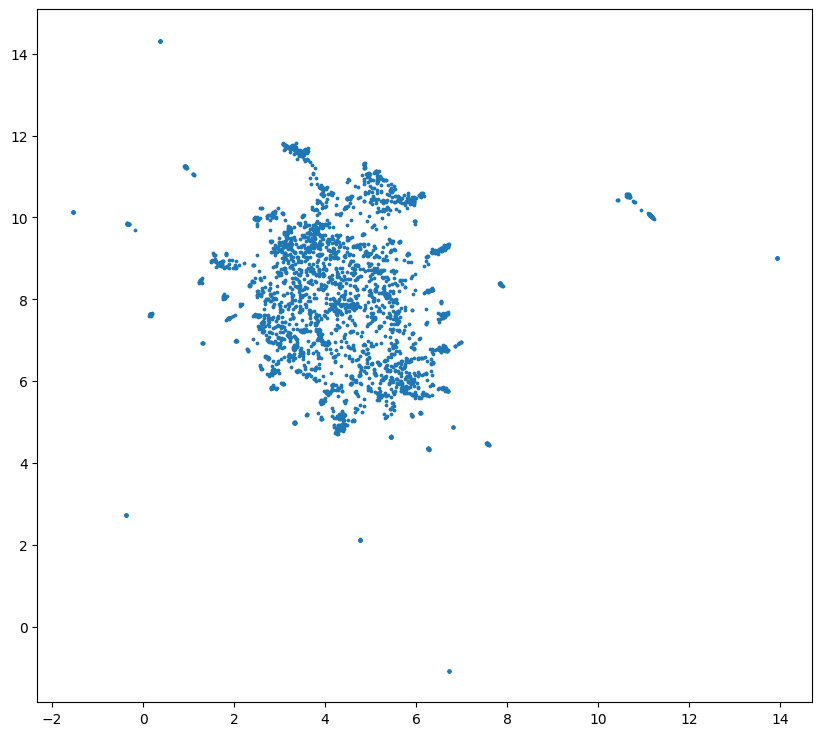

In [24]:
import umap.umap_ as umap
import warnings
warnings.filterwarnings('ignore')

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral');

Every dot in this plot is a product. There are several tiny clusters representing similar products.

# Recommending Products system Usage

Now, our next step is to suggest similar products for a certain product or a product’s vector.

Let's create a product-ID and product-description dictionary to easily map a product’s description to its ID and vice versa.

In [25]:
products = train_df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [26]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

Create a function to return top 5 similar products by defult.

In [27]:
def similar_products(v, n = 5):
    
    # extract most similar products
    ms = model.wv.most_similar([v], topn= n+1)[1:]
    
    # extract name and similarity score
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms  

Try the function 

In [28]:
products_dict['22112']

['CHOCOLATE HOT WATER BOTTLE']

In [29]:
similar_products(model.wv['22112'])


[('HOT WATER BOTTLE I AM SO POORLY', 0.8618147969245911),
 ('HOT WATER BOTTLE TEA AND SYMPATHY', 0.8166502714157104),
 ('RETROSPOT HEART HOT WATER BOTTLE', 0.8047968149185181),
 ('SCOTTIE DOG HOT WATER BOTTLE', 0.775870144367218),
 ('GREY HEART HOT WATER BOTTLE', 0.7414628863334656)]

The results are pretty relevant and match well with the input product.

BUUTT 

what we need is to recommend products based on the multiple purchases that made in the past. Let's see.


One simple solution is to take the average of all the vectors of the products the user has bought so far and use this vector to find similar products. 

In [30]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

Using validation list of purchase sequences. 

In [31]:
len(purchases_val[0]), len(purchases_val[1])

(67, 242)

The length of the first list of products purchased by a user is 247 and the secound is 696. We will pass this products’ sequence of the validation set to the function aggregate_vectors to return array of 100 dimensions

In [32]:
aggregate_vectors(purchases_val[0]).shape, aggregate_vectors(purchases_val[1]).shape

((100,), (100,))

Now we can use this result to get the most similar products:

In [33]:
similar_products(aggregate_vectors(purchases_val[11]))

[('CHILDRENS APRON APPLES DESIGN', 0.6663833260536194),
 ('SPACEBOY LUNCH BOX ', 0.6660316586494446),
 ('LUNCH BAG SPACEBOY DESIGN ', 0.659289538860321),
 ('LUNCH BAG SUKI DESIGN ', 0.6587213277816772),
 ('RETROSPOT TEA SET CERAMIC 11 PC ', 0.6576854586601257)]

In [34]:
similar_products(aggregate_vectors(purchases_val[11][-10:]))


[('LUNCH BAG APPLE DESIGN', 0.707604706287384),
 ('ROUND CAKE TIN VINTAGE RED', 0.698058009147644),
 ('LUNCH BAG VINTAGE LEAF DESIGN', 0.6937379240989685),
 ('LUNCH BAG CARS BLUE', 0.6868544816970825),
 ('ROUND CAKE TIN VINTAGE GREEN', 0.6857284307479858)]